# Implementing a bayesian normative model for cortical thickness using PYMC with MCMC

---

### package imports and basic functions

---

In [1]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3


In [2]:
# pymc libraries
import pymc as pm
import arviz as az
import xarray as xr
import patsy

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v4.2.2


In [3]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


In [4]:
# path setting
main_dir = os.path.abspath('../../../..')


## Load aggregated data

---

In [5]:
demography_df = pd.read_csv(f'{main_dir}/data/csv/demography_all_datasets.csv', index_col=0)


## Fit a hierarchical bayesian model with PYMC + MCMC

---

Hierarchical Bayesian Regression (HBR) is capable of modeling site variations as a rendom stochastic effect with a prior distribution. MCMC provides and exact solution to the problem but is known to be computationally expensive (read time-consuming) with hierarchical models and large samples.

The model below implements a nonlinear variation of thickness by age with intercepts that are influenced by site and sex. The model assumes a skewed normal distribution for thickness. Mean, variance, and skewness are all considered model variables that are fitted by observations. Mean and variance are considered to be affected by age, gender, and sex; whereas skewness is considered to be a fixed unknown variable.


In [7]:
%%time
# smaller sample for faster convergence
# sample_df = all_df.sample(200, random_state=1)
sample_df = demography_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
thickness = sample_df['thickness'].values
thickness_standardized = (thickness - thickness.mean()) / thickness.std()
site_idxs, sites = pd.factorize(sample_df['dataset'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])
   
# Splines to model nonlinear age effects on thickness
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
B_spline_age = patsy.dmatrix(
    "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
    {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
)

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs)),
}

mcmc_model = pm.Model(coords=coords)

# a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
with mcmc_model:
    # Declared input data
    sex_idx = pm.Data("sex_idx", sex_idxs, dims="obs_id", mutable=True)
    site_idx = pm.Data("site_idx", site_idxs, dims="obs_id", mutable=True)
    
    # Hyperpriors for site groups (as if we have random group effects)
    mu_intercept_site = pm.Normal('mu_intercept_site', mu=0, sigma=10)
    sigma_intercept_site = pm.HalfNormal("sigma_intercept_site", sigma=1)
    sigma_error_site = pm.HalfNormal("sigma_error_site", sigma=1)

    # Priors    
    # sex effects (similar to fixed sex effects (intercept only))
    intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=1, dims="sex")
    
    # site effects (similar to random site effects (intercept only))
    #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
    intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
    intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")
    
    # age splines
    w_age = pm.Normal("w_age", mu=0, sigma=1, size=B_spline_age.shape[1], dims="splines")
    
    # Estimated thickness
    thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx] + intercept_site[site_idx] + pm.math.dot(B_spline_age, w_age.T))

    # Model error
    # nonlinear age error
    w_error_age = pm.HalfNormal("w_error_age", sigma=1, size=B_spline_age.shape[1], dims="splines")
    
    # constant sex error
    error_sex = pm.HalfNormal("error_sex", sigma=1, dims="sex")
    
    # random site error
    error_site_offset = pm.HalfNormal("error_site_offset", sigma=1, dims="site")
    error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")
    
    # Error estimate
    thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx] + error_site[site_idx] + pm.math.dot(B_spline_age, w_error_age.T))
    
    # Skewness estimate
    thickness_skewness = pm.Normal("thickness_skewness", mu=0, sigma=10,)
    
    # Likelihood (sampling distribution) of observations
    # need to figure out how to bound the distribution
#     pm.Bound("thickness_like", pm.Normal, lower=(-thickness.mean() / thickness.std()))(
    thickness_like = pm.SkewNormal(
        "thickness_like",
        mu=thickness_est,
        sigma=thickness_error,
        alpha=thickness_skewness,
        observed=thickness_standardized,
        total_size=len(sample_df),
    )
    
    # inference with MCMC
    mcmc_model_idata = pm.sample_prior_predictive()
    mcmc_model_idata.extend(pm.sample(draws=2000, tune=2000, random_seed=1, chains=4, target_accept=0.9))
    pm.sample_posterior_predictive(mcmc_model_idata, extend_inferencedata=True)


Sampling: [error_sex, error_site_offset, intercept_sex, intercept_site_offset, mu_intercept_site, sigma_error_site, sigma_intercept_site, thickness_like, thickness_skewness, w_age, w_error_age]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_intercept_site, sigma_intercept_site, sigma_error_site, intercept_sex, intercept_site_offset, w_age, w_error_age, error_sex, error_site_offset, thickness_skewness]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 14118 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Sampling: [thickness_like]


CPU times: user 35min 5s, sys: 6min 35s, total: 41min 40s
Wall time: 3h 57min 45s


## Visualise fitted centiles

---

CPU times: user 6.55 s, sys: 3.91 s, total: 10.5 s
Wall time: 2.91 s


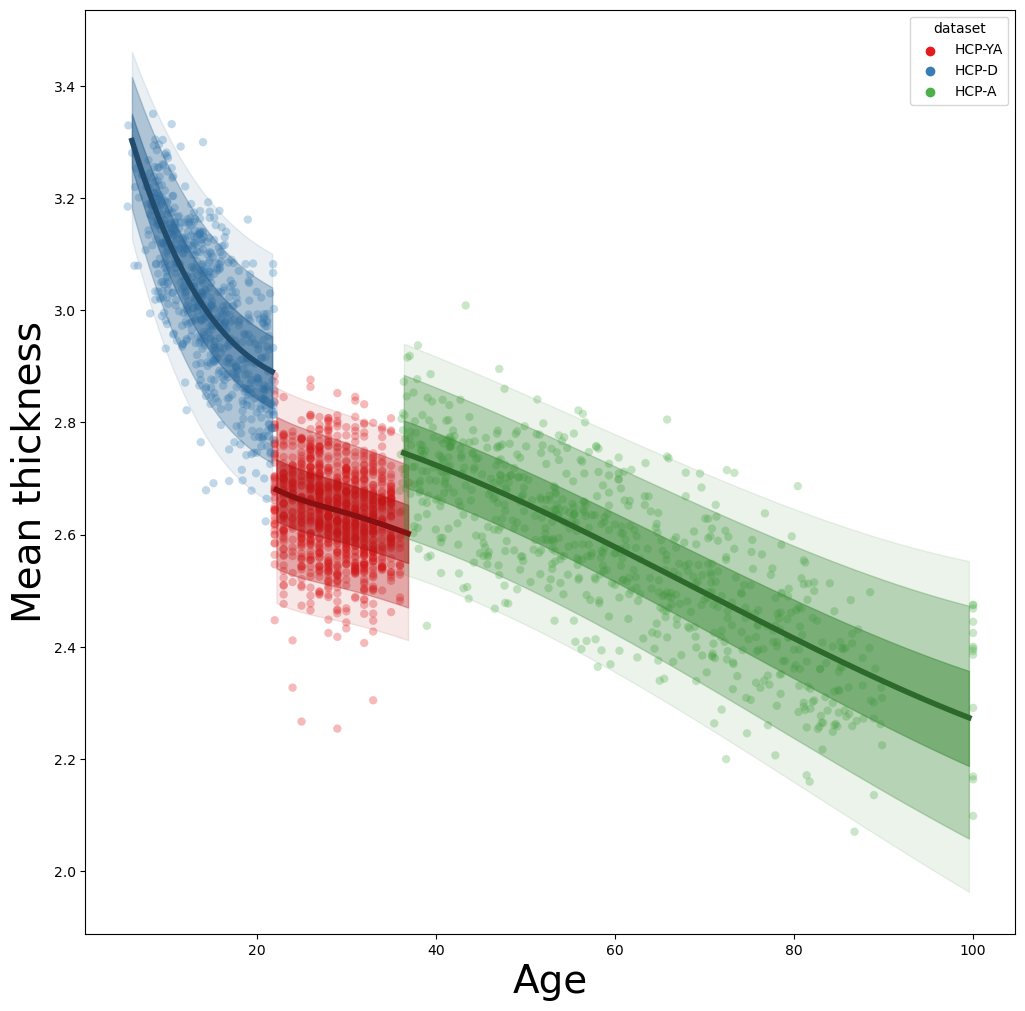

In [8]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

sns.scatterplot(
    data=demography_df,
    x='age',
    y='thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    post = mcmc_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )

    y_ppc_mu = (
        post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
        post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
        np.dot(
            prediction_B_spline_age,
            post['w_age'].stack(sample=("chain", "draw"))
        )
    )

    y_ppc_sigma = (
        post['error_sex'].stack(sample=("chain", "draw"))[0].data +
        post['error_site'].stack(sample=("chain", "draw"))[idx].data +
        np.dot(
            prediction_B_spline_age,
            post['w_error_age'].stack(sample=("chain", "draw"))
        )
    )

    y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu.mean(1) + stats.skewnorm.ppf(q=q, a=y_ppc_alpha.mean()) * y_ppc_sigma.mean(1)
            )  * thickness.std() +
            thickness.mean()
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )
